In [71]:
# Gain modulation RNN with oja learning on weight matrix
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from abb05_rep import SimpleNeuralNetwork
from tqdm import tqdm

In [72]:
# load the pickle file
with open('abb05_rep.pkl', 'rb') as f:
    model_rep = pickle.load(f)

In [73]:
# input and target
ndata = 200
xs = torch.linspace(0, 2 * torch.pi, ndata)
ys = torch.cos(xs)/4 + 0.5

In [119]:
# manual simulation
simu_epochs = 300
input_size = 230
theo_gain = 3 * np.ones((input_size, 1))
theo_shift = 1 * np.ones((input_size, 1))
init_gain = model_rep.gain.detach().numpy()
init_shift = model_rep.shift.detach().numpy()
init_weight = model_rep.weights.detach().numpy()
gc_thresh = np.sqrt(input_size) * 0.01
sc_thresh = np.sqrt(input_size) * 0.01
narrow_factor = 0.0001
hebbian_lr = 0.001
oja_alpha = 12

# create boundaries
has_boundary = True
gain_ub = np.maximum(init_gain, theo_gain)
gain_lb = np.minimum(init_gain, theo_gain)
shift_ub = np.maximum(init_shift, theo_shift)
shift_lb = np.minimum(init_shift, theo_shift)

# define noise
np.random.seed(42)
W = np.eye(input_size) * 0.001
x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=simu_epochs)).T * 0
x_noises = torch.tensor(x_noises, dtype=torch.float32)
x_noises[:,50::] += 0.1
simu_losses = []
gain_changes = []
shift_changes = []
weight_sums = []
epoch_loss = 0

for epoch in tqdm(range(simu_epochs), position=0, leave=True):

    # shuffle data
    perm_idx = torch.randperm(ndata)
    shuffled_xs = xs[perm_idx]
    shuffled_ys = ys[perm_idx]
    last_epoch_loss = epoch_loss
    epoch_loss = 0

    for x, y in zip(shuffled_xs, shuffled_ys):
        
        # establish model
        model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

        # forward
        inpu_ipl = model.gaussian_rf(x)
        actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
        # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
        model.input_activation = actv_ipl.clone()
        inpu_opl = torch.matmul(model.weights, actv_ipl)
        actv_opl = model.activation_func(3 * (inpu_opl - 1))
        model.output_activation = actv_opl.clone()

        # backprop
        optimizer = optim.SGD([model.gain, model.shift], lr=0.2)
        loss_func = nn.MSELoss()
        output = actv_opl.squeeze()
        loss = 0.5 * loss_func(output, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # update init gains and shifts
        init_gain = model.gain.detach().numpy()
        init_shift = model.shift.detach().numpy()
        gain_change = np.linalg.norm(init_gain - theo_gain, 2)
        shift_change = np.linalg.norm(init_shift - theo_shift, 2)

        # update weights
        if loss < 0.001:
            # Calculate Hebbian weight updates
            hebbian_update = model.output_activation * (model.input_activation).T
            # Regulation term of Oja
            rj_square = (model.output_activation**2).expand(-1, model.input_size)
            oja_regulation = oja_alpha * rj_square * model.weights
            # Oja's rule
            model.weights = model.weights + hebbian_lr * hebbian_update - hebbian_lr * oja_regulation            
            # update init weights
        init_weight = model.weights.detach().numpy()

        if last_epoch_loss > 0.01 and has_boundary == True:
            has_boundary = False
            print("boundary end!!!")

        # shrink shift and gain to init value
        if last_epoch_loss < 0.001 and has_boundary == False:
            # create boundaries
            gain_ub = np.maximum(init_gain, theo_gain)
            gain_lb = np.minimum(init_gain, theo_gain)
            shift_ub = np.maximum(init_shift, theo_shift)
            shift_lb = np.minimum(init_shift, theo_shift)
            has_boundary = True
            print("boundary start!!!")
        if has_boundary and last_epoch_loss < 0.001:
            # passively narrow the boundaries
            gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
            gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
            shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
            shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
            # # actively narrow the boundaries
            # if np.linalg.norm(gain_ub - theo_gain, 2) > gc_thresh:
            #     gain_ub -= narrow_factor * (gain_ub - theo_gain)
            # if np.linalg.norm(gain_lb - theo_gain, 2) > gc_thresh:
            #     gain_lb -= narrow_factor * (gain_lb - theo_gain)
            # if np.linalg.norm(shift_ub - theo_shift, 2) > sc_thresh:
            #     shift_ub -= narrow_factor * (shift_ub - theo_shift)
            # if np.linalg.norm(shift_lb - theo_shift, 2) > sc_thresh:
            #     shift_lb -= narrow_factor * (shift_lb - theo_shift)
        # pull gains and shifts back to into boundaries
        if has_boundary:
            init_gain = np.minimum(init_gain, gain_ub)
            init_gain = np.maximum(init_gain, gain_lb)
            init_shift = np.minimum(init_shift, shift_ub)
            init_shift = np.maximum(init_shift, shift_lb)

    # print losses
    epoch_loss /= ndata
    simu_losses.append(epoch_loss)
    gain_changes.append(gain_change)
    shift_changes.append(shift_change)
    weight_sums.append(np.sum(init_weight))

    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Loss: {epoch_loss}")

  1%|          | 2/300 [00:00<00:22, 13.49it/s]

Epoch: 0, Loss: 0.0007407195217008678


  8%|▊         | 23/300 [00:01<00:12, 22.76it/s]

Epoch: 20, Loss: 0.0007030882446568488


 15%|█▍        | 44/300 [00:01<00:11, 22.92it/s]

Epoch: 40, Loss: 0.0007144746740872065


 19%|█▊        | 56/300 [00:02<00:09, 24.93it/s]

boundary end!!!


 22%|██▏       | 65/300 [00:02<00:09, 24.91it/s]

Epoch: 60, Loss: 0.00870051797244777


 28%|██▊       | 83/300 [00:03<00:08, 24.79it/s]

Epoch: 80, Loss: 0.0039030357480297883


 35%|███▍      | 104/300 [00:04<00:08, 22.99it/s]

Epoch: 100, Loss: 0.0012902564616859102


 40%|███▉      | 119/300 [00:05<00:07, 22.75it/s]

boundary start!!!
Epoch: 120, Loss: 0.000975284412056947


 48%|████▊     | 143/300 [00:06<00:06, 22.50it/s]

Epoch: 140, Loss: 0.0010235090661244329


 55%|█████▍    | 164/300 [00:07<00:06, 22.43it/s]

Epoch: 160, Loss: 0.00102103931005864


 62%|██████▏   | 185/300 [00:08<00:04, 23.21it/s]

Epoch: 180, Loss: 0.0010520565763808775


 68%|██████▊   | 203/300 [00:08<00:04, 23.06it/s]

Epoch: 200, Loss: 0.0010865435714026716


 75%|███████▍  | 224/300 [00:09<00:03, 23.53it/s]

Epoch: 220, Loss: 0.0010625048753116339


 82%|████████▏ | 245/300 [00:10<00:02, 23.82it/s]

Epoch: 240, Loss: 0.0010123444667615566


 88%|████████▊ | 263/300 [00:11<00:01, 24.04it/s]

Epoch: 260, Loss: 0.0010463455961235012


 95%|█████████▍| 284/300 [00:12<00:00, 23.59it/s]

Epoch: 280, Loss: 0.0010609783689862695


100%|██████████| 300/300 [00:12<00:00, 23.29it/s]


In [157]:
# manual simulation 2
simu_epochs = 500
input_size = 230
theo_gain = 3 * np.ones((input_size, 1))
theo_shift = 1 * np.ones((input_size, 1))
init_gain = model_rep.gain.detach().numpy()
init_shift = model_rep.shift.detach().numpy()
init_weight = model_rep.weights.detach().numpy()
gc_thresh = np.sqrt(input_size) * 0.01
sc_thresh = np.sqrt(input_size) * 0.01
narrow_factor = 0.001
hebbian_lr = 0.001
oja_alpha = 12

# create boundaries
has_boundary = True
gain_ub = np.maximum(init_gain, theo_gain)
gain_lb = np.minimum(init_gain, theo_gain)
shift_ub = np.maximum(init_shift, theo_shift)
shift_lb = np.minimum(init_shift, theo_shift)

# define noise
np.random.seed(42)
W = np.eye(input_size) * 0.001
x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=simu_epochs)).T * 0
x_noises = torch.tensor(x_noises, dtype=torch.float32)
x_noises[:,50::] += 0.1
simu_losses = []
gain_changes = []
shift_changes = []
weight_sums = []
epoch_loss = 0
stage = 'backprop'

for epoch in tqdm(range(simu_epochs), position=0, leave=True):

    # shuffle data
    perm_idx = torch.randperm(ndata)
    shuffled_xs = xs[perm_idx]
    shuffled_ys = ys[perm_idx]
    last_epoch_loss = epoch_loss
    epoch_loss = 0

    # forced backprop when loss too large
    if last_epoch_loss > 0.01 and stage != 'backprop':
        stage = 'backprop'
        print("forced backprop!!!")
    # forced abandon boundary when loss too large
    if last_epoch_loss > 0.01 and has_boundary == True:
        has_boundary = False
        print("boundary end!!!")
    # start boundary when loss is small
    if last_epoch_loss < 0.001 and has_boundary == False:
        gain_ub = np.maximum(init_gain, theo_gain)
        gain_lb = np.minimum(init_gain, theo_gain)
        shift_ub = np.maximum(init_shift, theo_shift)
        shift_lb = np.minimum(init_shift, theo_shift)
        has_boundary = True
        print("boundary start!!!")
    # start hebbian when loss is small
    if last_epoch_loss < 0.001 and stage == 'backprop':
        stage = 'hebbian'
        print("hebbian start!!!")
    # narrow boundary and start backprop when hebbian convergence
    elif len(simu_losses) >= 5 and np.std(simu_losses[-5:]) < 0.001 and stage == 'hebbian':
        # passively narrow the boundaries
        gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
        gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
        shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
        shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
        # actively narrow the boundaries
        if np.linalg.norm(gain_ub - theo_gain, 2) > gc_thresh:
            gain_ub -= narrow_factor * (gain_ub - theo_gain)
        if np.linalg.norm(gain_lb - theo_gain, 2) > gc_thresh:
            gain_lb -= narrow_factor * (gain_lb - theo_gain)
        if np.linalg.norm(shift_ub - theo_shift, 2) > sc_thresh:
            shift_ub -= narrow_factor * (shift_ub - theo_shift)
        if np.linalg.norm(shift_lb - theo_shift, 2) > sc_thresh:
            shift_lb -= narrow_factor * (shift_lb - theo_shift)
        # pull back into boundary
        init_gain = np.minimum(init_gain, gain_ub)
        init_gain = np.maximum(init_gain, gain_lb)
        init_shift = np.minimum(init_shift, shift_ub)
        init_shift = np.maximum(init_shift, shift_lb)
        stage = 'backprop'
        print("converge!! start backprop!!!")

    for x, y in zip(shuffled_xs, shuffled_ys):
        
        # establish model
        model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

        # forward
        inpu_ipl = model.gaussian_rf(x)
        actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
        # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
        model.input_activation = actv_ipl.clone()
        inpu_opl = torch.matmul(model.weights, actv_ipl)
        actv_opl = model.activation_func(3 * (inpu_opl - 1))
        model.output_activation = actv_opl.clone()

        # loss
        output = actv_opl.squeeze()
        loss = 0.5 * loss_func(output, y)
        epoch_loss += loss.item()

        # backprop
        if stage == 'backprop':
            optimizer = optim.SGD([model.gain, model.shift], lr=0.2)
            loss_func = nn.MSELoss()
            loss.backward()
            optimizer.step()

        # update init gains and shifts
        init_gain = model.gain.detach().numpy()
        init_shift = model.shift.detach().numpy()
        gain_change = np.linalg.norm(init_gain - theo_gain, 2)
        shift_change = np.linalg.norm(init_shift - theo_shift, 2)
        
        # pull into boundary
        if has_boundary:
            init_gain = np.minimum(init_gain, gain_ub)
            init_gain = np.maximum(init_gain, gain_lb)
            init_shift = np.minimum(init_shift, shift_ub)
            init_shift = np.maximum(init_shift, shift_lb)

        # update weights
        if stage == 'hebbian':
            # Calculate Hebbian weight updates
            hebbian_update = model.output_activation * (model.input_activation).T
            # Regulation term of Oja
            rj_square = (model.output_activation**2).expand(-1, model.input_size)
            oja_regulation = oja_alpha * rj_square * model.weights
            # Oja's rule
            model.weights = model.weights + hebbian_lr * hebbian_update - hebbian_lr * oja_regulation            
            # update init weights
        init_weight = model.weights.detach().numpy()
        
    # print losses
    epoch_loss /= ndata
    simu_losses.append(epoch_loss)
    gain_changes.append(gain_change)
    shift_changes.append(shift_change)
    weight_sums.append(np.sum(init_weight))

    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Loss: {epoch_loss}")

  1%|          | 3/500 [00:00<00:20, 24.30it/s]

hebbian start!!!
Epoch: 0, Loss: 0.0026026209302552417
forced backprop!!!
boundary end!!!


  5%|▍         | 24/500 [00:00<00:18, 26.13it/s]

Epoch: 20, Loss: 0.0009184574358660313
boundary start!!!
hebbian start!!!
converge!! start backprop!!!
hebbian start!!!
converge!! start backprop!!!


  6%|▌         | 30/500 [00:01<00:18, 26.04it/s]

hebbian start!!!
converge!! start backprop!!!


  9%|▊         | 43/500 [00:01<00:16, 27.12it/s]

hebbian start!!!
converge!! start backprop!!!
Epoch: 40, Loss: 0.0007924338932301111
hebbian start!!!
converge!! start backprop!!!
hebbian start!!!
converge!! start backprop!!!


 10%|▉         | 49/500 [00:01<00:16, 27.20it/s]

hebbian start!!!
converge!! start backprop!!!
hebbian start!!!
converge!! start backprop!!!
hebbian start!!!
converge!! start backprop!!!


 11%|█         | 55/500 [00:02<00:16, 26.61it/s]

boundary end!!!


 13%|█▎        | 64/500 [00:02<00:16, 26.10it/s]

Epoch: 60, Loss: 0.00444985955420897


 17%|█▋        | 85/500 [00:03<00:15, 26.33it/s]

Epoch: 80, Loss: 0.0018102809840310386


 21%|██        | 106/500 [00:04<00:14, 26.81it/s]

Epoch: 100, Loss: 0.001142016456135746


 22%|██▏       | 112/500 [00:04<00:14, 27.08it/s]

boundary start!!!
hebbian start!!!
converge!! start backprop!!!


 25%|██▍       | 124/500 [00:04<00:14, 26.66it/s]

Epoch: 120, Loss: 0.0020156359225594043


 29%|██▉       | 145/500 [00:05<00:13, 26.21it/s]

Epoch: 140, Loss: 0.0020156410938710055


 33%|███▎      | 166/500 [00:06<00:12, 25.84it/s]

Epoch: 160, Loss: 0.002015579891215262


 37%|███▋      | 184/500 [00:07<00:12, 25.81it/s]

Epoch: 180, Loss: 0.002015622760744158


 41%|████      | 205/500 [00:07<00:11, 26.28it/s]

Epoch: 200, Loss: 0.0020155542232591374


 45%|████▌     | 226/500 [00:08<00:10, 26.40it/s]

Epoch: 220, Loss: 0.0020156209406413782


 49%|████▉     | 244/500 [00:09<00:09, 26.05it/s]

Epoch: 240, Loss: 0.0020156211933894585


 53%|█████▎    | 265/500 [00:10<00:08, 26.17it/s]

Epoch: 260, Loss: 0.002015618357376816


 57%|█████▋    | 286/500 [00:10<00:08, 26.32it/s]

Epoch: 280, Loss: 0.002015610112886925


 61%|██████    | 304/500 [00:11<00:07, 25.58it/s]

Epoch: 300, Loss: 0.002015700203946986


 65%|██████▌   | 325/500 [00:12<00:06, 25.68it/s]

Epoch: 320, Loss: 0.0020156449382270213


 69%|██████▉   | 346/500 [00:13<00:05, 26.22it/s]

Epoch: 340, Loss: 0.002015621165853929


 73%|███████▎  | 364/500 [00:14<00:05, 26.14it/s]

Epoch: 360, Loss: 0.0020156221172629783


 77%|███████▋  | 385/500 [00:14<00:04, 26.02it/s]

Epoch: 380, Loss: 0.002015599082876074


 81%|████████  | 406/500 [00:15<00:03, 25.54it/s]

Epoch: 400, Loss: 0.0020156135340542746


 85%|████████▍ | 424/500 [00:16<00:02, 26.06it/s]

Epoch: 420, Loss: 0.002015629009171258


 89%|████████▉ | 445/500 [00:17<00:02, 26.32it/s]

Epoch: 440, Loss: 0.002015613162450798


 93%|█████████▎| 466/500 [00:17<00:01, 26.26it/s]

Epoch: 460, Loss: 0.002015580946137101


 97%|█████████▋| 484/500 [00:18<00:00, 26.30it/s]

Epoch: 480, Loss: 0.0020156069316218696


100%|██████████| 500/500 [00:19<00:00, 25.98it/s]


In [303]:
# manual simulation 3
simu_epochs = 3000
input_size = 230
theo_gain = 3 * np.ones((input_size, 1))
theo_shift = 1 * np.ones((input_size, 1))
# init_gain = model_rep.gain.detach().numpy()
# init_shift = model_rep.shift.detach().numpy()
# init_weight = model_rep.weights.detach().numpy()
init_gain = 3 * np.ones((input_size, 1))
init_shift = 1 * np.ones((input_size, 1))
init_weight = np.ones((1, input_size)) / input_size * 5.5
gc_thresh = np.sqrt(input_size) * 0.01
sc_thresh = np.sqrt(input_size) * 0.01
narrow_factor = 0
max_narrow_factor = 0.001
narrow_up_rate = max_narrow_factor / 2000
hebbian_lr = 0
max_hebbian_lr = 0.001
hebbian_up_rate = max_hebbian_lr / 1000
oja_alpha = 12
has_backprop = True
has_boundary = False
has_hebbian = False

# define noise
np.random.seed(42)
W = np.eye(input_size) * 0.001
x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=simu_epochs)).T * 0
x_noises = torch.tensor(x_noises, dtype=torch.float32)
# x_noises += 0.1
simu_losses = []
gain_changes = []
shift_changes = []
weight_sums = []
epoch_loss = 0

for epoch in tqdm(range(simu_epochs), position=0, leave=True):

    # shuffle data
    perm_idx = torch.randperm(ndata)
    shuffled_xs = xs[perm_idx]
    shuffled_ys = ys[perm_idx]
    last_epoch_loss = epoch_loss
    epoch_loss = 0

    # update hebbian learning rate
    if has_hebbian:
        hebbian_lr += hebbian_up_rate
 
    if has_boundary:
        # update narrow factor
        narrow_factor += narrow_up_rate
        # actively narrow the boundaries
        if np.linalg.norm(gain_ub - theo_gain, 2) > gc_thresh:
            gain_ub -= narrow_factor * (gain_ub - theo_gain)
        if np.linalg.norm(gain_lb - theo_gain, 2) > gc_thresh:
            gain_lb -= narrow_factor * (gain_lb - theo_gain)
        if np.linalg.norm(shift_ub - theo_shift, 2) > sc_thresh:
            shift_ub -= narrow_factor * (shift_ub - theo_shift)
        if np.linalg.norm(shift_lb - theo_shift, 2) > sc_thresh:
            shift_lb -= narrow_factor * (shift_lb - theo_shift)

    for x, y in zip(shuffled_xs, shuffled_ys):
        
        # establish model
        model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

        # forward
        inpu_ipl = model.gaussian_rf(x)
        actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
        # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
        model.input_activation = actv_ipl.clone()
        inpu_opl = torch.matmul(model.weights, actv_ipl)
        actv_opl = model.activation_func(3 * (inpu_opl - 1))
        model.output_activation = actv_opl.clone()

        # loss
        loss_func = nn.MSELoss()
        output = actv_opl.squeeze()
        loss = 0.5 * loss_func(output, y)
        epoch_loss += loss.item()

        # backprop
        if has_backprop:
            optimizer = optim.SGD([model.gain, model.shift], lr=0.2)
            loss.backward()
            optimizer.step()

        # update init gains and shifts
        init_gain = model.gain.detach().numpy()
        init_shift = model.shift.detach().numpy()
        gain_change = np.linalg.norm(init_gain - theo_gain, 2)
        shift_change = np.linalg.norm(init_shift - theo_shift, 2)

        # start hebbian and shrinkage
        if epoch > 10 and last_epoch_loss < 0.001 and has_hebbian == False:
            has_hebbian = True
            has_backprop = False
        if epoch > 10 and last_epoch_loss < 0.001 and has_boundary == False:
            # create boundaries
            gain_ub = np.maximum(init_gain, theo_gain)
            gain_lb = np.minimum(init_gain, theo_gain)
            shift_ub = np.maximum(init_shift, theo_shift)
            shift_lb = np.minimum(init_shift, theo_shift)
            has_boundary = True
            print("learning start!!!")

        # update weights
        if has_hebbian:
            # Calculate Hebbian weight updates
            hebbian_update = model.output_activation * (model.input_activation).T
            # Regulation term of Oja
            rj_square = (model.output_activation**2).expand(-1, model.input_size)
            oja_regulation = oja_alpha * rj_square * model.weights
            # Oja's rule
            model.weights = model.weights + hebbian_lr * hebbian_update - hebbian_lr * oja_regulation            
            # update init weights
        init_weight = model.weights.detach().numpy()

        # shrink shift and gain to init value
        if has_boundary:
            # passively narrow the boundaries
            gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
            gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
            shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
            shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
            # pull gains and shifts back to into boundaries
            init_gain = np.minimum(init_gain, gain_ub)
            init_gain = np.maximum(init_gain, gain_lb)
            init_shift = np.minimum(init_shift, shift_ub)
            init_shift = np.maximum(init_shift, shift_lb)

    # print losses
    epoch_loss /= ndata
    simu_losses.append(epoch_loss)
    gain_changes.append(gain_change)
    shift_changes.append(shift_change)
    weight_sums.append(np.sum(init_weight))

    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Loss: {epoch_loss}")

  0%|          | 2/3000 [00:00<03:49, 13.07it/s]

Epoch: 0, Loss: 0.014320228484268682


  1%|          | 25/3000 [00:01<01:57, 25.25it/s]

Epoch: 20, Loss: 0.0013786624027169125
learning start!!!


  2%|▏         | 47/3000 [00:01<01:39, 29.69it/s]

Epoch: 40, Loss: 0.0006677730237439405


  2%|▏         | 65/3000 [00:02<01:36, 30.38it/s]

Epoch: 60, Loss: 0.004410536614304874


  3%|▎         | 85/3000 [00:03<01:33, 31.03it/s]

Epoch: 80, Loss: 0.008796672147998374


  4%|▎         | 105/3000 [00:03<01:33, 30.97it/s]

Epoch: 100, Loss: 0.01029539419481381


  4%|▍         | 125/3000 [00:04<01:32, 31.20it/s]

Epoch: 120, Loss: 0.010657280458059262


  5%|▍         | 145/3000 [00:05<01:31, 31.22it/s]

Epoch: 140, Loss: 0.010722856699983234


  6%|▌         | 165/3000 [00:05<01:31, 31.08it/s]

Epoch: 160, Loss: 0.01069321543849057


  6%|▌         | 185/3000 [00:06<01:29, 31.31it/s]

Epoch: 180, Loss: 0.010663904948791015


  7%|▋         | 205/3000 [00:06<01:29, 31.28it/s]

Epoch: 200, Loss: 0.010627356471728149


  8%|▊         | 225/3000 [00:07<01:29, 31.05it/s]

Epoch: 220, Loss: 0.010612807654867211


  8%|▊         | 245/3000 [00:08<01:28, 31.10it/s]

Epoch: 240, Loss: 0.010572277953305476


  9%|▉         | 265/3000 [00:08<01:27, 31.32it/s]

Epoch: 260, Loss: 0.01054107683420483


 10%|▉         | 285/3000 [00:09<01:26, 31.28it/s]

Epoch: 280, Loss: 0.01048378910592433


 10%|█         | 305/3000 [00:10<01:27, 30.93it/s]

Epoch: 300, Loss: 0.01043965951787918


 11%|█         | 325/3000 [00:10<01:26, 31.02it/s]

Epoch: 320, Loss: 0.01038777044983476


 12%|█▏        | 345/3000 [00:11<01:25, 31.20it/s]

Epoch: 340, Loss: 0.010337035638132762


 12%|█▏        | 365/3000 [00:12<01:24, 31.34it/s]

Epoch: 360, Loss: 0.010277282273486463


 13%|█▎        | 385/3000 [00:12<01:24, 31.10it/s]

Epoch: 380, Loss: 0.010219489749534887


 14%|█▎        | 405/3000 [00:13<01:23, 31.25it/s]

Epoch: 400, Loss: 0.01014081755728597


 14%|█▍        | 425/3000 [00:14<01:22, 31.34it/s]

Epoch: 420, Loss: 0.010084374934618268


 15%|█▍        | 445/3000 [00:14<01:21, 31.29it/s]

Epoch: 440, Loss: 0.009994631578074405


 16%|█▌        | 465/3000 [00:15<01:21, 31.25it/s]

Epoch: 460, Loss: 0.009929434730742846


 16%|█▌        | 485/3000 [00:15<01:20, 31.18it/s]

Epoch: 480, Loss: 0.009890376904019718


 17%|█▋        | 505/3000 [00:16<01:19, 31.31it/s]

Epoch: 500, Loss: 0.00977588595157126


 18%|█▊        | 525/3000 [00:17<01:18, 31.41it/s]

Epoch: 520, Loss: 0.009776013647272066


 18%|█▊        | 545/3000 [00:17<01:18, 31.17it/s]

Epoch: 540, Loss: 0.00965646556271679


 19%|█▉        | 565/3000 [00:18<01:18, 31.21it/s]

Epoch: 560, Loss: 0.009559449742591824


 20%|█▉        | 585/3000 [00:19<01:16, 31.40it/s]

Epoch: 580, Loss: 0.009426230913992042


 20%|██        | 605/3000 [00:19<01:16, 31.31it/s]

Epoch: 600, Loss: 0.009334756823699629


 21%|██        | 625/3000 [00:20<01:15, 31.30it/s]

Epoch: 620, Loss: 0.009285329163204636


 22%|██▏       | 645/3000 [00:21<01:15, 31.30it/s]

Epoch: 640, Loss: 0.009199297388030062


 22%|██▏       | 665/3000 [00:21<01:14, 31.32it/s]

Epoch: 660, Loss: 0.00905072159053148


 23%|██▎       | 685/3000 [00:22<01:13, 31.29it/s]

Epoch: 680, Loss: 0.008997082481383317


 24%|██▎       | 705/3000 [00:22<01:13, 31.06it/s]

Epoch: 700, Loss: 0.00888883190544732


 24%|██▍       | 725/3000 [00:23<01:12, 31.26it/s]

Epoch: 720, Loss: 0.008784406175420542


 25%|██▍       | 745/3000 [00:24<01:12, 31.28it/s]

Epoch: 740, Loss: 0.008650017466172812


 26%|██▌       | 765/3000 [00:24<01:11, 31.34it/s]

Epoch: 760, Loss: 0.008561159048828983


 26%|██▌       | 785/3000 [00:25<01:10, 31.27it/s]

Epoch: 780, Loss: 0.008443286649679464


 27%|██▋       | 805/3000 [00:26<01:10, 31.29it/s]

Epoch: 800, Loss: 0.008333457612836668


 28%|██▊       | 825/3000 [00:26<01:09, 31.20it/s]

Epoch: 820, Loss: 0.008244055676321572


 28%|██▊       | 845/3000 [00:27<01:08, 31.26it/s]

Epoch: 840, Loss: 0.008125298696156733


 29%|██▉       | 865/3000 [00:28<01:08, 31.17it/s]

Epoch: 860, Loss: 0.007981598557677999


 30%|██▉       | 885/3000 [00:28<01:07, 31.37it/s]

Epoch: 880, Loss: 0.007928315331377007


 30%|███       | 905/3000 [00:29<01:07, 31.24it/s]

Epoch: 900, Loss: 0.007795231398847022


 31%|███       | 925/3000 [00:30<01:06, 31.14it/s]

Epoch: 920, Loss: 0.007616794501471418


 32%|███▏      | 945/3000 [00:30<01:05, 31.33it/s]

Epoch: 940, Loss: 0.007565638357601472


 32%|███▏      | 965/3000 [00:31<01:05, 31.25it/s]

Epoch: 960, Loss: 0.007418866882289505


 33%|███▎      | 985/3000 [00:31<01:04, 31.25it/s]

Epoch: 980, Loss: 0.007257085981455624


 34%|███▎      | 1005/3000 [00:32<01:03, 31.21it/s]

Epoch: 1000, Loss: 0.007125842193922978


 34%|███▍      | 1025/3000 [00:33<01:03, 31.27it/s]

Epoch: 1020, Loss: 0.007022791196940261


 35%|███▍      | 1045/3000 [00:33<01:02, 31.22it/s]

Epoch: 1040, Loss: 0.00683882147699137


 36%|███▌      | 1065/3000 [00:34<01:01, 31.44it/s]

Epoch: 1060, Loss: 0.006872733433907712


 36%|███▌      | 1085/3000 [00:35<01:01, 31.38it/s]

Epoch: 1080, Loss: 0.006620128263737419


 37%|███▋      | 1105/3000 [00:35<01:00, 31.27it/s]

Epoch: 1100, Loss: 0.006560009588390727


 38%|███▊      | 1125/3000 [00:36<00:59, 31.34it/s]

Epoch: 1120, Loss: 0.006397384230792653


 38%|███▊      | 1145/3000 [00:37<00:59, 31.20it/s]

Epoch: 1140, Loss: 0.0062575450488572045


 39%|███▉      | 1165/3000 [00:37<00:59, 30.93it/s]

Epoch: 1160, Loss: 0.00605090834229415


 40%|███▉      | 1185/3000 [00:38<00:58, 31.17it/s]

Epoch: 1180, Loss: 0.005960389147366527


 40%|████      | 1205/3000 [00:39<00:57, 31.27it/s]

Epoch: 1200, Loss: 0.0058335059710749705


 41%|████      | 1225/3000 [00:39<00:57, 31.10it/s]

Epoch: 1220, Loss: 0.005699570327878263


 42%|████▏     | 1245/3000 [00:40<00:56, 31.34it/s]

Epoch: 1240, Loss: 0.005601658211921938


 42%|████▏     | 1265/3000 [00:40<00:55, 31.47it/s]

Epoch: 1260, Loss: 0.005528136172744525


 43%|████▎     | 1285/3000 [00:41<00:54, 31.43it/s]

Epoch: 1280, Loss: 0.0053255622836621795


 44%|████▎     | 1305/3000 [00:42<00:54, 31.33it/s]

Epoch: 1300, Loss: 0.0052588634164318845


 44%|████▍     | 1325/3000 [00:42<00:53, 31.13it/s]

Epoch: 1320, Loss: 0.005116122762194095


 45%|████▍     | 1345/3000 [00:43<00:53, 31.22it/s]

Epoch: 1340, Loss: 0.004961012467312145


 46%|████▌     | 1365/3000 [00:44<00:52, 31.15it/s]

Epoch: 1360, Loss: 0.004769822899042993


 46%|████▌     | 1385/3000 [00:44<00:51, 31.23it/s]

Epoch: 1380, Loss: 0.0046883259882926605


 47%|████▋     | 1405/3000 [00:45<00:51, 31.10it/s]

Epoch: 1400, Loss: 0.004569345236349653


 48%|████▊     | 1425/3000 [00:46<00:50, 31.22it/s]

Epoch: 1420, Loss: 0.00445380501892302


 48%|████▊     | 1445/3000 [00:46<00:49, 31.32it/s]

Epoch: 1440, Loss: 0.004323190396499968


 49%|████▉     | 1465/3000 [00:47<00:49, 31.15it/s]

Epoch: 1460, Loss: 0.004219522439581879


 50%|████▉     | 1485/3000 [00:48<00:48, 31.15it/s]

Epoch: 1480, Loss: 0.004092373584192792


 50%|█████     | 1505/3000 [00:48<00:48, 31.12it/s]

Epoch: 1500, Loss: 0.003956712503128559


 51%|█████     | 1525/3000 [00:49<00:47, 31.12it/s]

Epoch: 1520, Loss: 0.0038779430796308588


 52%|█████▏    | 1545/3000 [00:49<00:46, 31.15it/s]

Epoch: 1540, Loss: 0.0037780222682834187


 52%|█████▏    | 1565/3000 [00:50<00:45, 31.33it/s]

Epoch: 1560, Loss: 0.0037179510033396924


 53%|█████▎    | 1585/3000 [00:51<00:45, 31.26it/s]

Epoch: 1580, Loss: 0.0035796904518143437


 54%|█████▎    | 1605/3000 [00:51<00:44, 31.31it/s]

Epoch: 1600, Loss: 0.003449318267051782


 54%|█████▍    | 1625/3000 [00:52<00:43, 31.45it/s]

Epoch: 1620, Loss: 0.0034120013829519458


 55%|█████▍    | 1645/3000 [00:53<00:43, 31.18it/s]

Epoch: 1640, Loss: 0.0033301875226585762


 56%|█████▌    | 1665/3000 [00:53<00:42, 31.17it/s]

Epoch: 1660, Loss: 0.003119406827732549


 56%|█████▌    | 1685/3000 [00:54<00:42, 31.20it/s]

Epoch: 1680, Loss: 0.0030403933392597992


 57%|█████▋    | 1705/3000 [00:55<00:41, 31.27it/s]

Epoch: 1700, Loss: 0.002984669713418171


 57%|█████▊    | 1725/3000 [00:55<00:40, 31.15it/s]

Epoch: 1720, Loss: 0.002897756475070423


 58%|█████▊    | 1745/3000 [00:56<00:40, 31.37it/s]

Epoch: 1740, Loss: 0.002800097757699105


 59%|█████▉    | 1765/3000 [00:56<00:39, 31.45it/s]

Epoch: 1760, Loss: 0.002738122373884835


 60%|█████▉    | 1785/3000 [00:57<00:39, 31.07it/s]

Epoch: 1780, Loss: 0.0026830266512479282


 60%|██████    | 1805/3000 [00:58<00:38, 31.10it/s]

Epoch: 1800, Loss: 0.0025778866155671664


 61%|██████    | 1825/3000 [00:58<00:37, 31.29it/s]

Epoch: 1820, Loss: 0.002601608724507969


 62%|██████▏   | 1845/3000 [00:59<00:37, 31.20it/s]

Epoch: 1840, Loss: 0.002520882782409899


 62%|██████▏   | 1865/3000 [01:00<00:36, 31.27it/s]

Epoch: 1860, Loss: 0.0024461302638519554


 63%|██████▎   | 1885/3000 [01:00<00:35, 31.26it/s]

Epoch: 1880, Loss: 0.0023977506851224463


 64%|██████▎   | 1905/3000 [01:01<00:34, 31.30it/s]

Epoch: 1900, Loss: 0.0023800854355067714


 64%|██████▍   | 1925/3000 [01:02<00:34, 31.24it/s]

Epoch: 1920, Loss: 0.002440978806844214


 65%|██████▍   | 1945/3000 [01:02<00:34, 31.00it/s]

Epoch: 1940, Loss: 0.0022329202236869607


 66%|██████▌   | 1965/3000 [01:03<00:33, 31.18it/s]

Epoch: 1960, Loss: 0.0022969188797287645


 66%|██████▌   | 1985/3000 [01:04<00:32, 31.32it/s]

Epoch: 1980, Loss: 0.0023758051730692386


 67%|██████▋   | 2005/3000 [01:04<00:31, 31.33it/s]

Epoch: 2000, Loss: 0.0023033733930788005


 68%|██████▊   | 2025/3000 [01:05<00:31, 31.24it/s]

Epoch: 2020, Loss: 0.0022402824943128508


 68%|██████▊   | 2045/3000 [01:05<00:30, 31.31it/s]

Epoch: 2040, Loss: 0.0021132523380219936


 69%|██████▉   | 2065/3000 [01:06<00:29, 31.29it/s]

Epoch: 2060, Loss: 0.0023294626379720285


 70%|██████▉   | 2085/3000 [01:07<00:29, 30.87it/s]

Epoch: 2080, Loss: 0.0024146535602631047


 70%|███████   | 2105/3000 [01:07<00:28, 31.28it/s]

Epoch: 2100, Loss: 0.0024409821239532903


 71%|███████   | 2125/3000 [01:08<00:27, 31.25it/s]

Epoch: 2120, Loss: 0.0021330323661095463


 72%|███████▏  | 2145/3000 [01:09<00:27, 31.20it/s]

Epoch: 2140, Loss: 0.0026348021187004634


 72%|███████▏  | 2165/3000 [01:09<00:26, 31.26it/s]

Epoch: 2160, Loss: 0.0025415714533301072


 73%|███████▎  | 2185/3000 [01:10<00:26, 31.31it/s]

Epoch: 2180, Loss: 0.0023435002824408


 74%|███████▎  | 2205/3000 [01:11<00:25, 31.27it/s]

Epoch: 2200, Loss: 0.0027301939998869785


 74%|███████▍  | 2225/3000 [01:11<00:24, 31.23it/s]

Epoch: 2220, Loss: 0.0025486513689975255


 75%|███████▍  | 2245/3000 [01:12<00:24, 31.27it/s]

Epoch: 2240, Loss: 0.0031010525382953345


 76%|███████▌  | 2265/3000 [01:13<00:23, 31.36it/s]

Epoch: 2260, Loss: 0.002797290684102336


 76%|███████▌  | 2285/3000 [01:13<00:22, 31.22it/s]

Epoch: 2280, Loss: 0.002314068572304677


 77%|███████▋  | 2305/3000 [01:14<00:22, 31.20it/s]

Epoch: 2300, Loss: 0.002805547181633301


 78%|███████▊  | 2325/3000 [01:14<00:21, 31.35it/s]

Epoch: 2320, Loss: 0.0029823137015046086


 78%|███████▊  | 2345/3000 [01:15<00:20, 31.28it/s]

Epoch: 2340, Loss: 0.0030484681800408


 79%|███████▉  | 2365/3000 [01:16<00:20, 30.79it/s]

Epoch: 2360, Loss: 0.0039095789966086154


 80%|███████▉  | 2385/3000 [01:16<00:19, 31.28it/s]

Epoch: 2380, Loss: 0.002875056636694353


 80%|████████  | 2405/3000 [01:17<00:19, 31.19it/s]

Epoch: 2400, Loss: 0.0031228986330097542


 81%|████████  | 2425/3000 [01:18<00:18, 31.11it/s]

Epoch: 2420, Loss: 0.003237640424949859


 82%|████████▏ | 2445/3000 [01:18<00:17, 31.19it/s]

Epoch: 2440, Loss: 0.0031364872241195483


 82%|████████▏ | 2465/3000 [01:19<00:17, 31.25it/s]

Epoch: 2460, Loss: 0.0040521742098463594


 83%|████████▎ | 2485/3000 [01:20<00:16, 31.15it/s]

Epoch: 2480, Loss: 0.003743666117463409


 84%|████████▎ | 2505/3000 [01:20<00:15, 31.32it/s]

Epoch: 2500, Loss: 0.0038877486676102534


 84%|████████▍ | 2525/3000 [01:21<00:15, 31.33it/s]

Epoch: 2520, Loss: 0.0033478221133455667


 85%|████████▍ | 2545/3000 [01:22<00:14, 31.32it/s]

Epoch: 2540, Loss: 0.0047862273438062175


 86%|████████▌ | 2565/3000 [01:22<00:13, 31.31it/s]

Epoch: 2560, Loss: 0.003948816412236198


 86%|████████▌ | 2585/3000 [01:23<00:13, 31.20it/s]

Epoch: 2580, Loss: 0.00446795116687241


 87%|████████▋ | 2605/3000 [01:23<00:12, 31.32it/s]

Epoch: 2600, Loss: 0.005443866836668008


 88%|████████▊ | 2625/3000 [01:24<00:11, 31.33it/s]

Epoch: 2620, Loss: 0.0046206716067272065


 88%|████████▊ | 2645/3000 [01:25<00:11, 31.26it/s]

Epoch: 2640, Loss: 0.004403843275036294


 89%|████████▉ | 2665/3000 [01:25<00:10, 31.36it/s]

Epoch: 2660, Loss: 0.004674639248191293


 90%|████████▉ | 2685/3000 [01:26<00:10, 31.28it/s]

Epoch: 2680, Loss: 0.005535740342801745


 90%|█████████ | 2705/3000 [01:27<00:09, 31.20it/s]

Epoch: 2700, Loss: 0.006049489606987351


 91%|█████████ | 2725/3000 [01:27<00:08, 31.17it/s]

Epoch: 2720, Loss: 0.006365506911317027


 92%|█████████▏| 2745/3000 [01:28<00:08, 31.24it/s]

Epoch: 2740, Loss: 0.005243799432320806


 92%|█████████▏| 2765/3000 [01:29<00:07, 31.23it/s]

Epoch: 2760, Loss: 0.005788046938349822


 93%|█████████▎| 2785/3000 [01:29<00:06, 30.90it/s]

Epoch: 2780, Loss: 0.006552665881239115


 94%|█████████▎| 2805/3000 [01:30<00:06, 31.13it/s]

Epoch: 2800, Loss: 0.0074652312553141085


 94%|█████████▍| 2825/3000 [01:31<00:05, 31.17it/s]

Epoch: 2820, Loss: 0.006991809958687733


 95%|█████████▍| 2845/3000 [01:31<00:04, 31.25it/s]

Epoch: 2840, Loss: 0.007073511922453726


 96%|█████████▌| 2865/3000 [01:32<00:04, 31.22it/s]

Epoch: 2860, Loss: 0.009677805118168124


 96%|█████████▌| 2885/3000 [01:32<00:03, 31.36it/s]

Epoch: 2880, Loss: 0.009089891524660061


 97%|█████████▋| 2905/3000 [01:33<00:03, 31.18it/s]

Epoch: 2900, Loss: 0.00663319513886429


 98%|█████████▊| 2925/3000 [01:34<00:02, 31.08it/s]

Epoch: 2920, Loss: 0.007775652279603946


 98%|█████████▊| 2945/3000 [01:34<00:01, 31.17it/s]

Epoch: 2940, Loss: 0.008132950477493068


 99%|█████████▉| 2965/3000 [01:35<00:01, 31.02it/s]

Epoch: 2960, Loss: 0.007730485029265992


100%|█████████▉| 2985/3000 [01:36<00:00, 31.29it/s]

Epoch: 2980, Loss: 0.010851728621373126


100%|██████████| 3000/3000 [01:36<00:00, 31.04it/s]


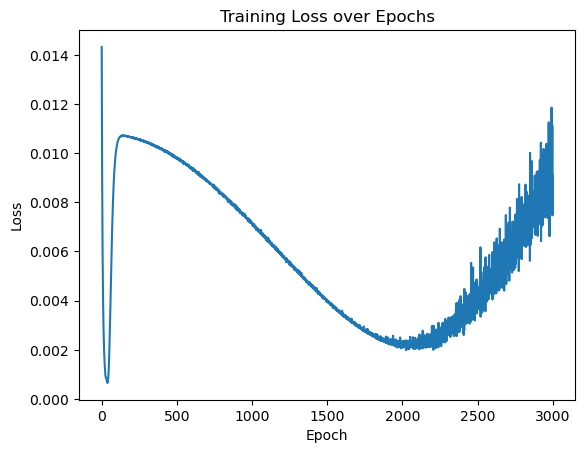

In [304]:
# Plotting the loss
plt.plot(range(simu_epochs), simu_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,0.01])
plt.title('Training Loss over Epochs')
# plt.savefig('abb05_loss.png')
plt.show()

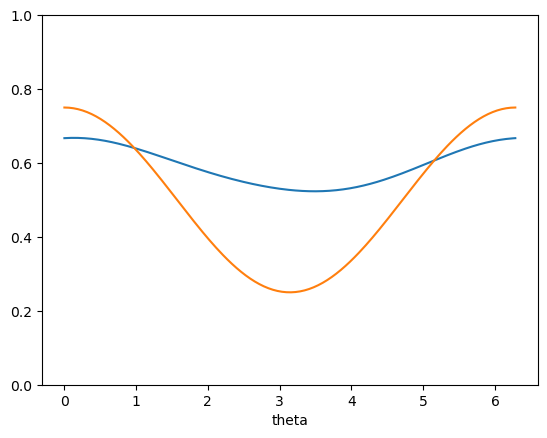

In [302]:
# Plotting the outputs
model.eval()
outputs = []
for x in xs:
    output = model(x)
    outputs.append(output.item())
plt.plot(xs, outputs)
plt.plot(xs, ys, label='target')
plt.ylim([0,1])
plt.xlabel("theta")
# plt.savefig('abb05_outputs.png')
plt.show()

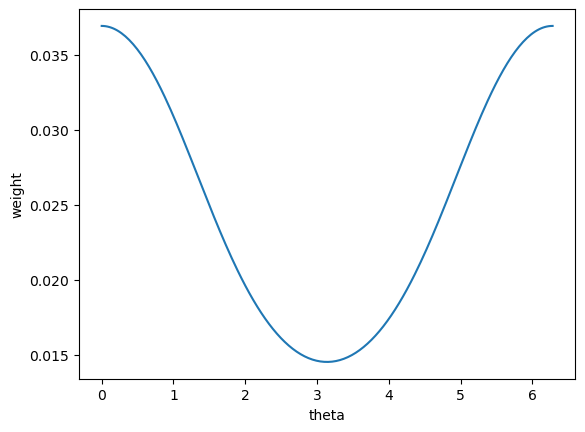

In [293]:
final_weight = model.weights.detach().numpy()
plt.plot(np.linspace(0, 2 * np.pi, model.input_size), final_weight.flatten())
# plt.ylim([0,8])
plt.xlabel("theta")
plt.ylabel("weight")
# plt.savefig('abb05_ws.png')
plt.show()

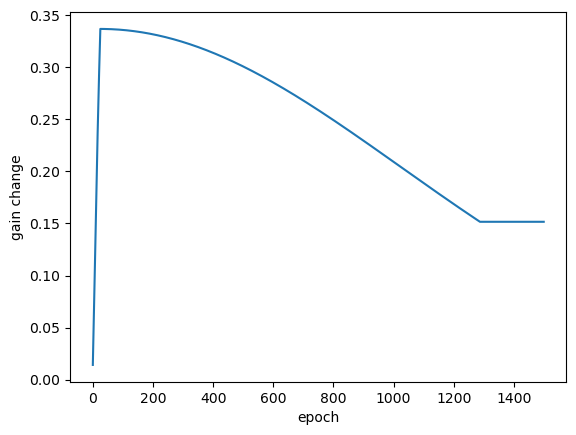

In [294]:
plt.plot(np.arange(simu_epochs), gain_changes)
plt.xlabel("epoch")
plt.ylabel("gain change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_gc.png')
plt.show()

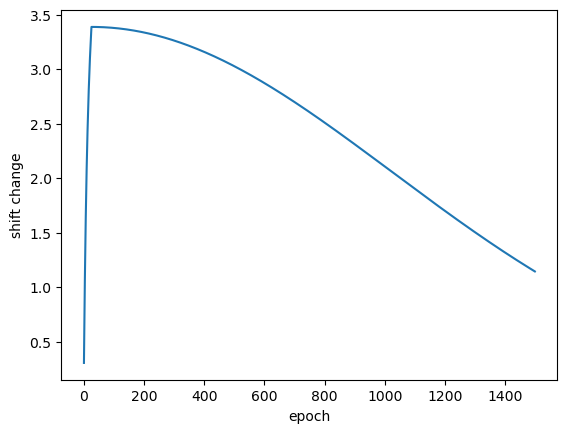

In [295]:
plt.plot(np.arange(simu_epochs), shift_changes)
plt.xlabel("epoch")
plt.ylabel("shift change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_sc.png')
plt.show()

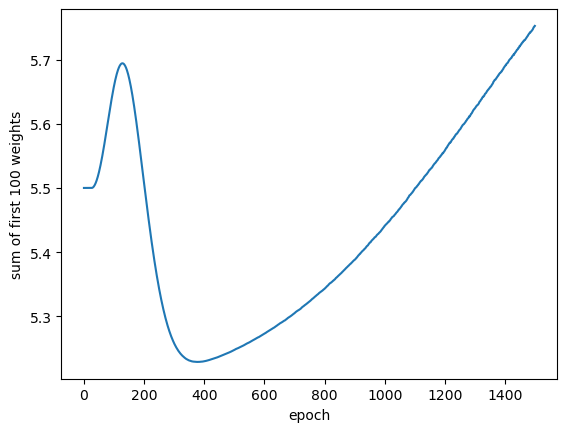

In [296]:
plt.plot(np.arange(simu_epochs), weight_sums)
# plt.ylim([0,8])
plt.xlabel("epoch")
plt.ylabel("sum of first 100 weights")
# plt.savefig('abb05_ws.png')
plt.show()

In [297]:
rates = []
for x in xs:
    input = model.gaussian_rf(x)
    rate = model.activation_func(model.gain * (input - model.shift))
    rates.append(rate)
rates = torch.cat(rates, dim=1)
rates = rates.detach().numpy().round(4)
rates

array([[0.5664, 0.5661, 0.565 , ..., 0.565 , 0.5661, 0.5664],
       [0.5661, 0.5664, 0.5659, ..., 0.5634, 0.5651, 0.5661],
       [0.5652, 0.5661, 0.5663, ..., 0.5612, 0.5636, 0.5652],
       ...,
       [0.5652, 0.5636, 0.5612, ..., 0.5663, 0.5661, 0.5652],
       [0.5661, 0.5651, 0.5634, ..., 0.5659, 0.5664, 0.5661],
       [0.5664, 0.5661, 0.565 , ..., 0.565 , 0.5661, 0.5664]],
      dtype=float32)

Text(0, 0.5, 'firing rate')

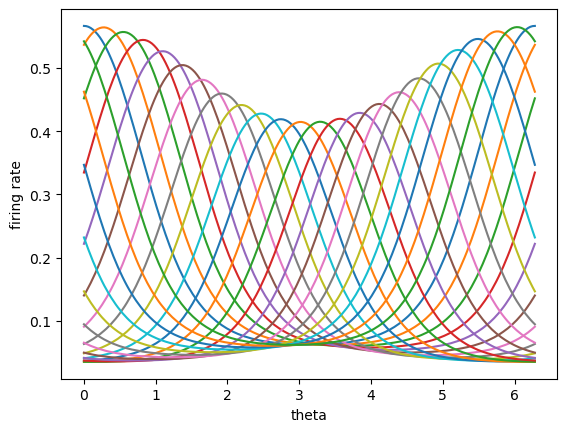

In [298]:
for i in np.arange(0,model.input_size,10):
    thisr = rates[i,:]
    plt.plot(xs, thisr)
plt.xlabel("theta")
plt.ylabel("firing rate")
# plt.savefig('abb05_rf.png')

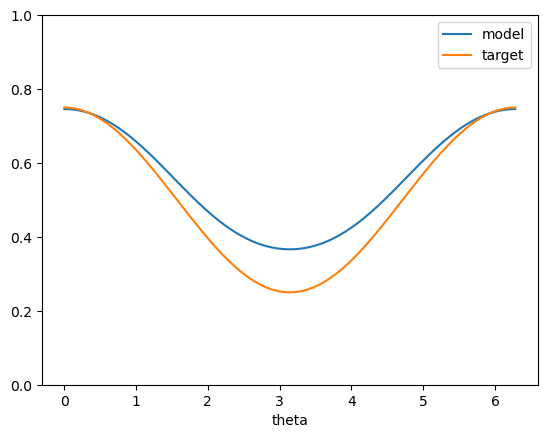

In [299]:
# Plotting the outputs
model.gain = model.init_gain
model.shift = model.init_shift
model.eval()
outputs = []
for x in xs:
    output = model(x)
    outputs.append(output.item())
plt.plot(xs, outputs, label='model')
plt.plot(xs, ys, label='target')
plt.ylim([0,1])
plt.xlabel("theta")
plt.legend()
# plt.savefig('abb05_outputs_nosup.png')